In [13]:
import os
import zipfile
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import entropy, skew, kurtosis
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam

In [14]:
import tkinter as tk
from tkinter import filedialog

root = tk.Tk()
root.withdraw()
file_path = filedialog.askopenfilename()
print("Selected file:", file_path)


Selected file: C:/Users/Bhavesh Samal/Downloads/dataset.zip


In [ ]:
import zipfile
import os

zip_path = "D:\Clg vt\major project\dataset.zip"
extract_path = "D:\Clg vt\major project\extracted_dataset"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction complete.")


In [15]:
import zipfile
import os
import io # Import the io module

# zip_path = 'dataset.zip'
extract_path = '/content/extracted_dataset'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)


# Assuming file_path contains the path to the zip file
if file_path:
    try:
        # Open the zip file using the file path
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

        print(f"Successfully extracted files from {file_path} to {extract_path}:")
        # List files - only if extraction was successful
        for root, dirs, files_list in os.walk(extract_path):
            for file in files_list:
                print(os.path.join(root, file))

    except zipfile.BadZipFile:
        print(f"Error: The file {file_path} is not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred while processing {file_path}: {e}")
else:
    print("Error: No file was uploaded.")

Successfully extracted files from C:/Users/Bhavesh Samal/Downloads/dataset.zip to /content/extracted_dataset:
/content/extracted_dataset\dataset\3032446_0002_ppg_abp.csv
/content/extracted_dataset\dataset\3032446_0003_ppg_abp.csv
/content/extracted_dataset\dataset\3032446_0004_ppg_abp.csv
/content/extracted_dataset\dataset\3032446_0013_ppg_abp.csv
/content/extracted_dataset\dataset\3032446_0014_ppg_abp.csv
/content/extracted_dataset\dataset\3032446_0015_ppg_abp.csv
/content/extracted_dataset\dataset\3032446_0016_ppg_abp.csv
/content/extracted_dataset\dataset\3032446_0017_ppg_abp.csv
/content/extracted_dataset\dataset\3032446_0019_ppg_abp.csv
/content/extracted_dataset\dataset\3032446_0020_ppg_abp.csv
/content/extracted_dataset\dataset\3032446_0021_ppg_abp.csv
/content/extracted_dataset\dataset\3482610_0027_ppg_abp.csv
/content/extracted_dataset\dataset\3482610_0028_ppg_abp.csv
/content/extracted_dataset\dataset\3482610_0029_ppg_abp.csv
/content/extracted_dataset\dataset\3482610_0030_pp

In [16]:
sample_path = "/content/extracted_dataset/dataset/3032446_0002_ppg_abp.csv"
df = pd.read_csv(sample_path)

print(df.head())
print(df.columns)

        PPG        ABP
0  0.647059  130.46875
1  0.643137  131.25000
2  0.643137  132.03125
3  0.639216  132.03125
4  0.639216  131.25000
Index(['PPG', 'ABP'], dtype='object')


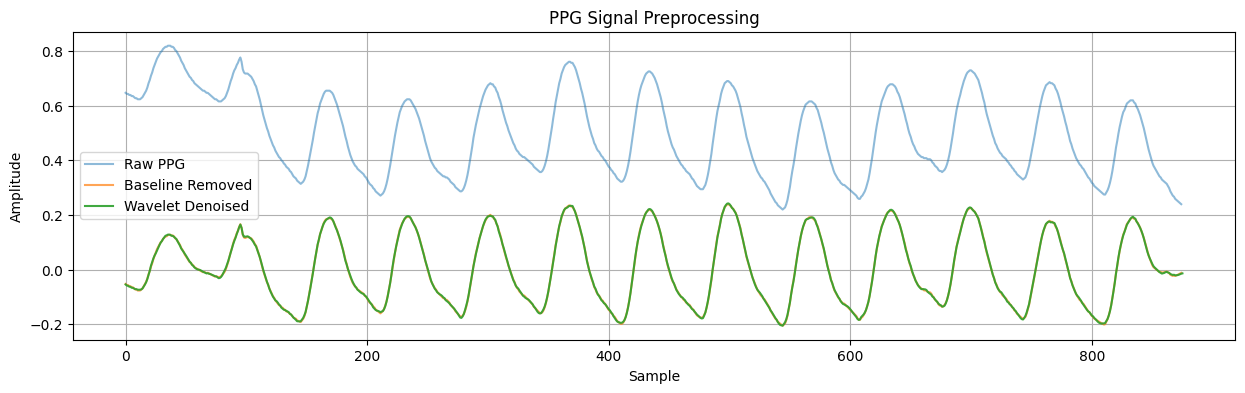

In [18]:
def highpass_filter(signal, cutoff=0.5, fs=125, order=3):
    nyquist = 0.5 * fs
    norm_cutoff = cutoff / nyquist
    b, a = butter(order, norm_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

ppg_filtered = highpass_filter(df['PPG'])


# # === Step 2: Wavelet Denoising ===
def wavelet_denoise(signal, wavelet='db4', level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs[1:] = [pywt.threshold(c, np.std(c)/2, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

ppg_denoised = wavelet_denoise(ppg_filtered)

# # === Optional: Normalize (for plotting only) ===
ppg_denoised_norm = (ppg_denoised - np.min(ppg_denoised)) / (np.max(ppg_denoised) - np.min(ppg_denoised))

# # === Plot for Visualization ===
plt.figure(figsize=(15, 4))
plt.plot(df['PPG'][:1000], label='Raw PPG', alpha=0.5)
plt.plot(ppg_filtered[:1000], label='Baseline Removed', alpha=0.7)
plt.plot(ppg_denoised[:1000], label='Wavelet Denoised', alpha=0.9)
plt.title("PPG Signal Preprocessing")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
import scipy.signal

def remove_baseline_wander(signal):
    return scipy.signal.detrend(signal)

def wavelet_denoise(signal, wavelet='db4', level=2, threshold_scale=0.2):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = threshold_scale * np.max(np.abs(coeffs[-1]))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

# Apply preprocessing
ppg_detrended = remove_baseline_wander(df['PPG'])
ppg_denoised = wavelet_denoise(ppg_detrended)

print("Detrended PPG shape:", ppg_detrended.shape)
print("Denoised PPG shape:", ppg_denoised.shape)

Detrended PPG shape: (875,)
Denoised PPG shape: (876,)


✅ Window shape: (256,)
✅ Scalogram shape: (63, 256)


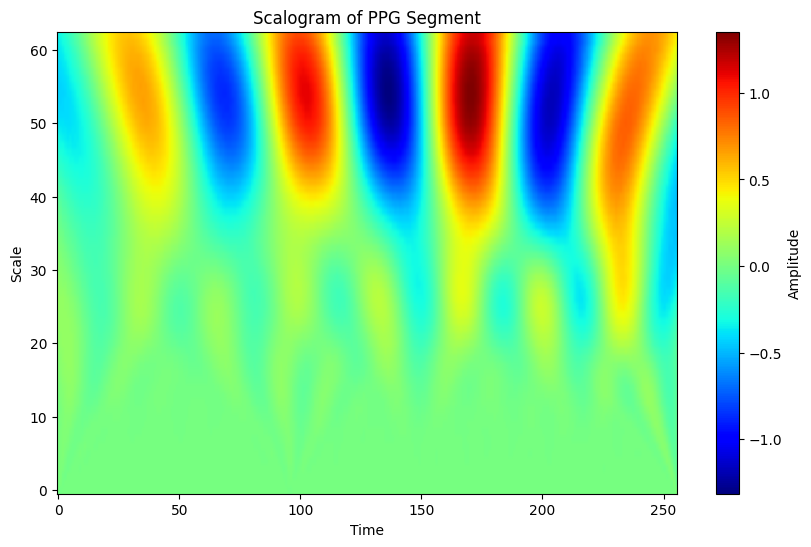

In [22]:
def generate_scalogram(signal, widths=np.arange(1, 64), wavelet='morl'): # Changed wavelet to 'morl'
    # Use pywt.cwt instead of scipy.signal.cwt
    scalogram, _ = pywt.cwt(signal, widths, wavelet) # Use the wavelet argument
    return scalogram


# Example window length
window_length = 256

# Take one segment
# Assuming ppg_denoised is available from previous cells
if 'ppg_denoised' in locals():
    sample_ppg_window = ppg_denoised[:window_length]

    print("✅ Window shape:", sample_ppg_window.shape)

    scalo = generate_scalogram(sample_ppg_window)

    print("✅ Scalogram shape:", scalo.shape)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(scalo, cmap='jet', aspect='auto', origin='lower')
    plt.colorbar(label='Amplitude')
    plt.title('Scalogram of PPG Segment')
    plt.xlabel('Time')
    plt.ylabel('Scale')
    plt.show()
else:
    print("Error: 'ppg_denoised' not found. Please run the previous cells to preprocess the PPG data.")

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cwt, ricker

# 4.1 Generate single scalogram
def generate_scalogram(signal, widths=np.arange(1, 64)):
    scalogram = cwt(signal, ricker, widths)
    return scalogram

# 4.2 Example single window
window_length = 256
sample_ppg_window = ppg_denoised[:window_length]
print("Window shape:", sample_ppg_window.shape)

scalo = generate_scalogram(sample_ppg_window)
print("Scalogram shape:", scalo.shape)

plt.figure(figsize=(10, 6))
plt.imshow(scalo, cmap='jet', aspect='auto', origin='lower')
plt.colorbar(label='Amplitude')
plt.title('Scalogram of PPG Segment')
plt.xlabel('Time')
plt.ylabel('Scale')
plt.show()

# 4.3 Create dataset from whole signal
def create_scalogram_dataset(ppg_signal, labels, window_length=256, step=128):
    X_images = []
    y_pairs = []
    for start in range(0, len(ppg_signal) - window_length, step):
        end = start + window_length
        segment = ppg_signal[start:end]
        scalo = generate_scalogram(segment)
        X_images.append(scalo)
        avg_label = np.mean(labels[start:end], axis=0)
        y_pairs.append(avg_label)
    return np.array(X_images), np.array(y_pairs)

X, y = create_scalogram_dataset(ppg_denoised, labels, window_length=256, step=128)

print("X shape:", X.shape)
print("y shape:", y.shape)

# 4.4 Visualize one example
plt.imshow(X[0], cmap='jet', aspect='auto', origin='lower')
plt.colorbar()
plt.title(f"Example Scalogram - SBP: {y[0][0]:.1f}, DBP: {y[0][1]:.1f}")
plt.xlabel('Time')
plt.ylabel('Scale')
plt.show()

ImportError: cannot import name 'cwt' from 'scipy.signal' (c:\Users\Bhavesh Samal\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\__init__.py)

In [28]:
X = X[..., np.newaxis]  # shape becomes (N, 63, 256, 1)
print("✅ X shape after adding channel:", X.shape)

NameError: name 'X' is not defined

In [29]:
import matplotlib.pyplot as plt
import cv2
from scipy.signal import cwt, ricker

def generate_scalogram(signal, widths=np.arange(1, 128)):
    cwtmatr = cwt(signal, ricker, widths)
    return cwtmatr

scalogram = generate_scalogram(ppg_denoised)

plt.imshow(scalogram, extent=[0,1,1,128], cmap='jet', aspect='auto')
plt.title('Scalogram')
plt.show()


ModuleNotFoundError: No module named 'cv2'